# ``Taming Performance Variability''

### <font color='red'> Testbed Coverage analysis.</font>

In [1]:
import os, sys
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
#import seaborn.apionly as sns
import seaborn as sns
import matplotlib.dates as md
from matplotlib import gridspec
import matplotlib.patches as patches
import datetime as dt
from collections import OrderedDict 
from collections import deque
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import warnings
from scipy.stats import norm
from IPython.display import IFrame
from IPython.display import Markdown, display
from IPython.display import FileLink, FileLinks
import calendar

# warnings.filterwarnings(action='once')

# plot_show_and_save() defined in bench_lib/common.py makes this magic unnecessary 
# (all plots should use plot_show_and_save())
#%matplotlib inline

# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Read all inputs from this directory
source_dir = "../data/raw-data/"
# Save all dataframes and plots into this directory 
dest_dir = "output/"

if not os.path.isdir(dest_dir):
    os.mkdir(dest_dir)

# db -- dictinary with keys - table names, values - dataframes with table data
db = {}

for f in os.listdir(source_dir):
    if ".csv" in f:
        db[os.path.splitext(f)[0]] = pd.read_csv(source_dir + f)
    
# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# If vebose is set, additional debug info will be printed. Use this flag throughout the notebook
verbose = True

if verbose:
    print "Keys: ", db.keys()
    for k, df in db.iteritems():
        #print "Sample from %s:" % k 
        #print df.head(3), "\n\n" 
        print "Columns in %s:" % k, df.columns.tolist(), "\n"

# Include common helper functions. You can see the avilable files and their code 
# if you use JupyterHub's file browser to navigate to the specifed directory 
sys.path.append("bench-lib/")
from common import *

# The warning showing up in the output comes from statsmodels, not our code 

/opt/conda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Keys:  ['disk_info', 'iperf3_info', 'iperf3_results', 'ping_results', 'env_info', 'membench_info', 'disk_results', 'fio_info', 'stream_info', 'network_info', 'mem_results', 'ping_info']
Columns in disk_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'disk_name', 'disk_model', 'disk_serial', 'disk_size', 'npartitions', 'disk_type'] 

Columns in iperf3_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'version', 'local_ip', 'local_port', 'remote_ip', 'remote_port', 'remote_nodeid', 'protocol', 'num_streams', 'buffer_size', 'omitted_intervals', 'duration', 'time_units'] 

Columns in iperf3_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'reverse', 'retransmits', 'local_cpu_util', 'remote_cpu_util', 'median', 'max', 'min', 'mean', 'stdev', 'sum_sent', 'sum_received', 'units'] 

Columns in ping_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'runtime', 'packets_sent', 'packets_received', 'packet_loss', 'max', 'min', 'mean', 'stdev', 'ipg', 'ewma', 'units'] 

Colu

In [2]:
# Now, all datasets are values in the db dictionary (keys correspond to dataset names used in the actual database).

# Print high-level info 

print "The earliest disk perf sample: ", dt.datetime.fromtimestamp(db['disk_results']['timestamp'].min())
print "The latest disk perf sample: ", dt.datetime.fromtimestamp(db['disk_results']['timestamp'].max())

print "The earliest memory perf sample: ", dt.datetime.fromtimestamp(db['mem_results']['timestamp'].min())
print "The latest memory perf sample: ", dt.datetime.fromtimestamp(db['mem_results']['timestamp'].max())

print "Total number of samples: ", len(db['disk_results'])

The earliest disk perf sample:  2017-05-20 09:18:32
The latest disk perf sample:  2018-04-04 18:12:08
The earliest memory perf sample:  2017-05-20 09:18:32
The latest memory perf sample:  2018-04-04 18:12:08
Total number of samples:  141408


Importing lists of all nodes...
	Hardware Type c6320: 84 nodes
	Hardware Type c8220: 96 nodes
	Hardware Type c220g2: 163 nodes
	Hardware Type c220g1: 90 nodes
	Hardware Type m400: 315 nodes
	Hardware Type m510: 270 nodes

Setting heatmap cmap...


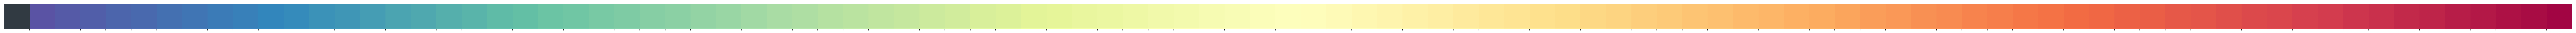

In [3]:
# Import the list of all nodes for each hardware type
allnodes = {}
nodes_path = '../data/nodes/'

print "Importing lists of all nodes..."

for f in os.listdir(nodes_path):
    with open(nodes_path + f) as openfile:
        nodelist = openfile.readlines()[0].strip('\n').split(',')
        nodelist.sort()
        allnodes[f[:-4]] = nodelist
        print "\tHardware Type " + f[:-4] + ": " + str(len(nodelist)) + " nodes"
    openfile.close()

# Testing out custom cmap
print "\nSetting heatmap cmap..."
raw_cmap = sns.color_palette("Spectral_r", 100)
spectral_cmap = ['#313a42']
for tuple in raw_cmap:
    new_tuple = ()
    for idx,val in enumerate(tuple):
        new_tuple = new_tuple + ((val * 255),)
    spectral_cmap.append('#%02x%02x%02x' % new_tuple)
#print spectral_cmap
sns.set_palette(spectral_cmap)
sns.palplot(sns.color_palette())
plt.show()

Before Filtering:  10619
After failure Filtering:  10501
After timestamp Filtering:  10400


Total Runs:  10400
Total Machines:  835
Mean Runs per Node:  12.4550898204
Median Runs per Node:  8.0


**Hardware Type: c220g1**

	Number of nodes tested/Total number of nodes: 88/90
	Total runs:  800
	Min and max counts:  4 31
	Mean and median counts (rounded):  9 7


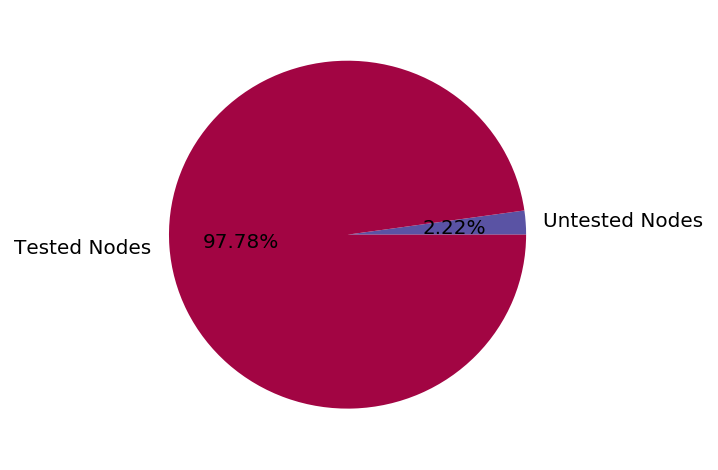

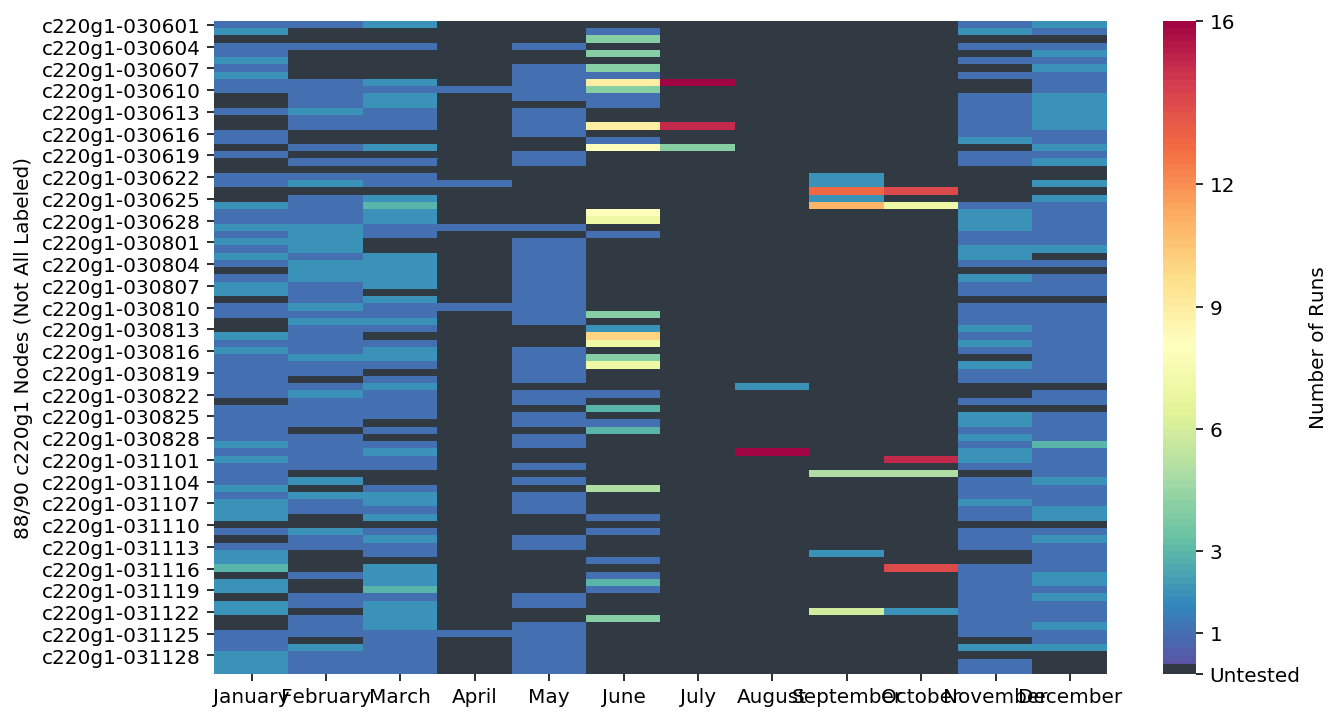

**Hardware Type: c220g2**

	Number of nodes tested/Total number of nodes: 125/163
	Total runs:  1527
	Min and max counts:  1 83
	Mean and median counts (rounded):  12 8


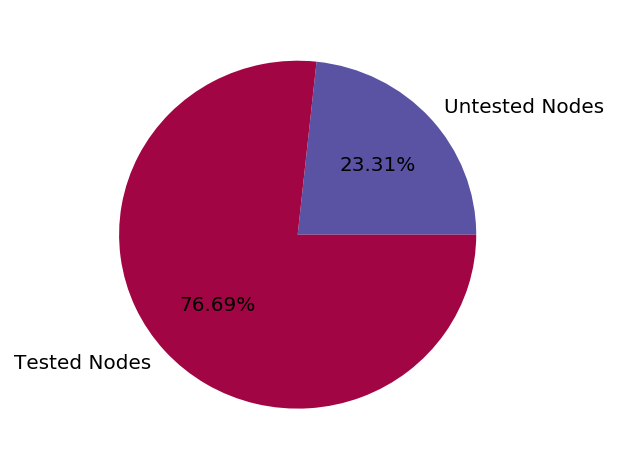

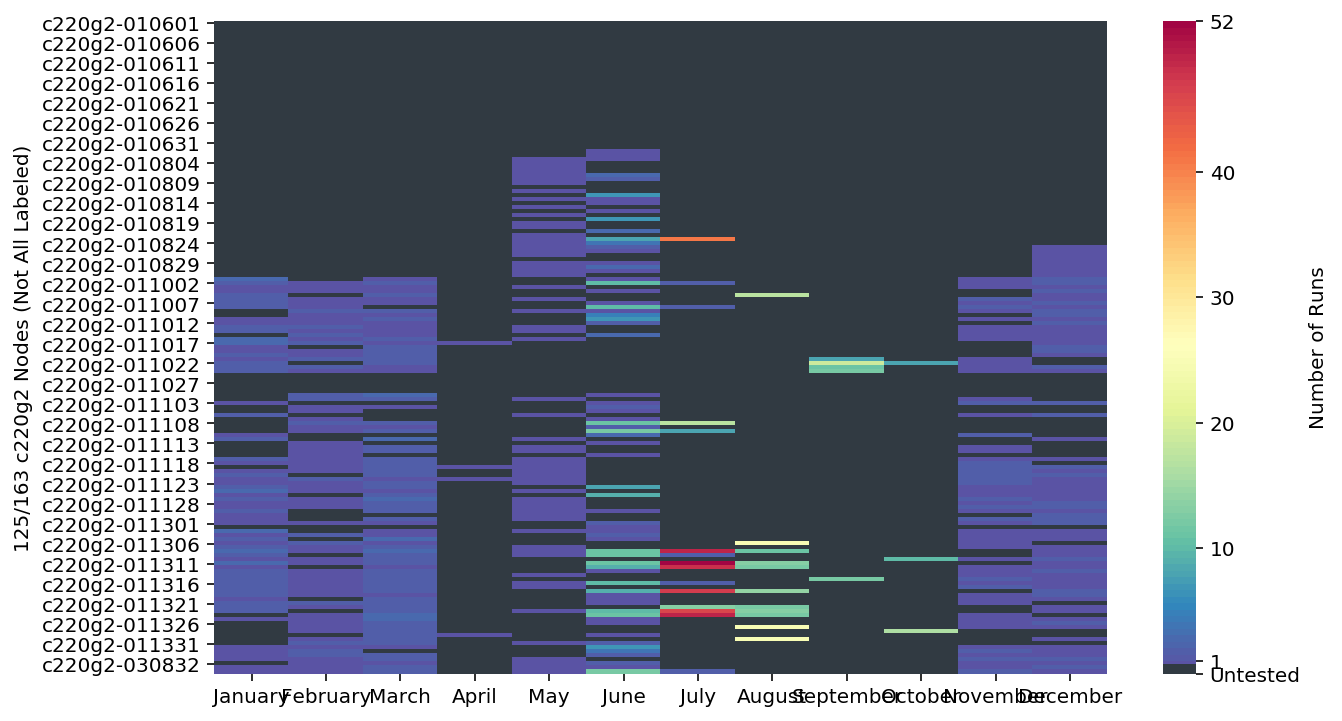

**Hardware Type: c6320**

	Number of nodes tested/Total number of nodes: 82/84
	Total runs:  741
	Min and max counts:  1 36
	Mean and median counts (rounded):  9 8


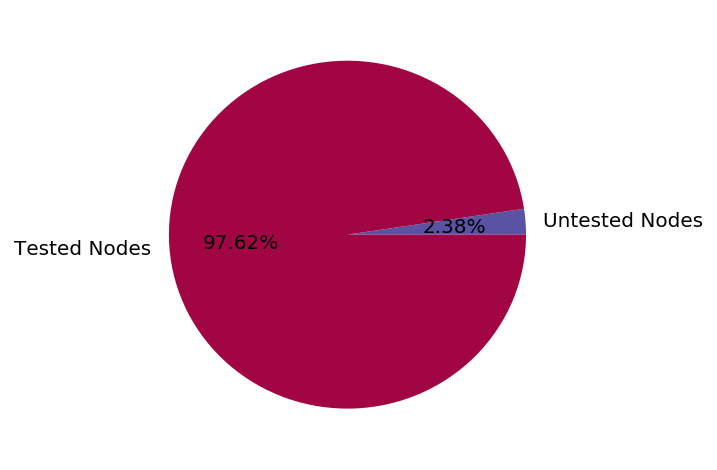

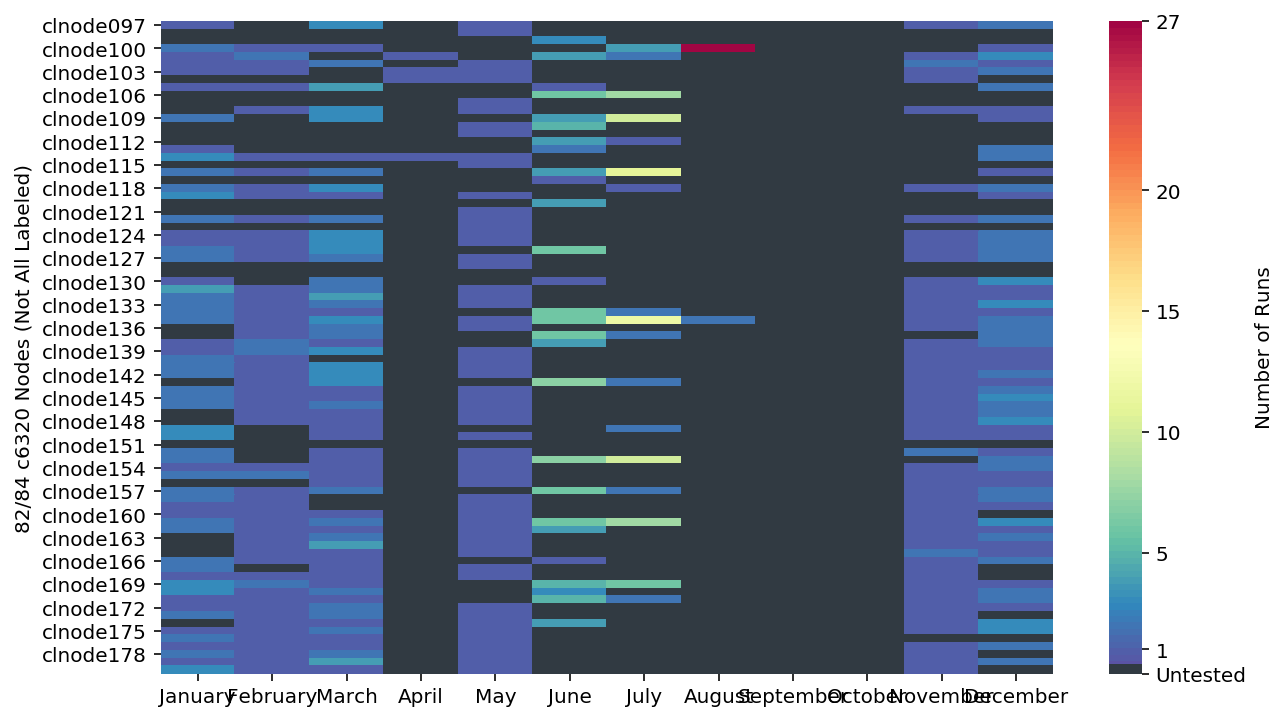

**Hardware Type: c8220**

	Number of nodes tested/Total number of nodes: 96/96
	Total runs:  1742
	Min and max counts:  6 68
	Mean and median counts (rounded):  18 12


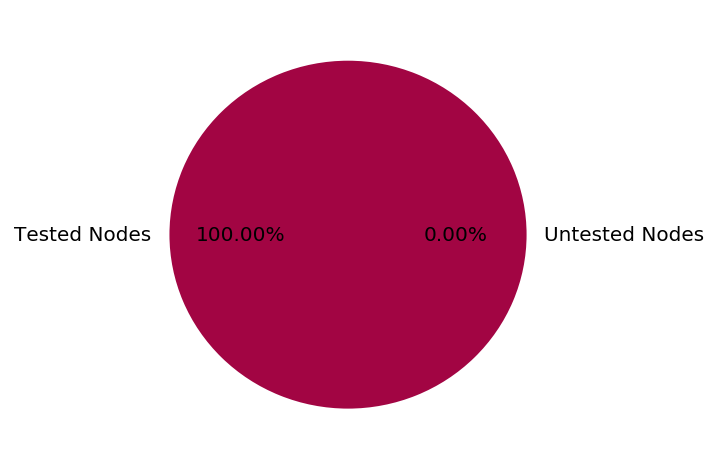

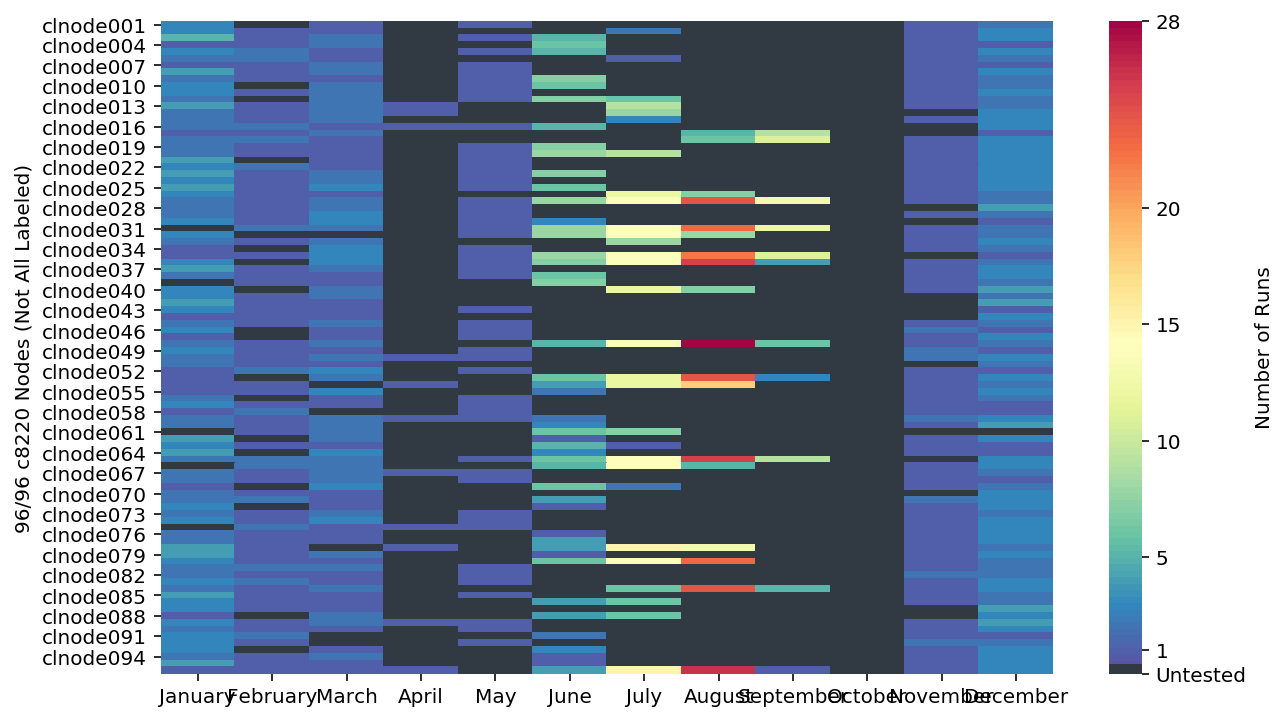

**Hardware Type: m400**

	Number of nodes tested/Total number of nodes: 223/315
	Total runs:  3583
	Min and max counts:  4 95
	Mean and median counts (rounded):  16 8


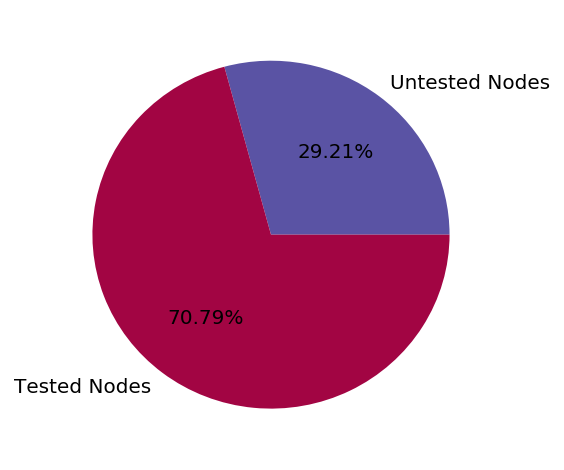

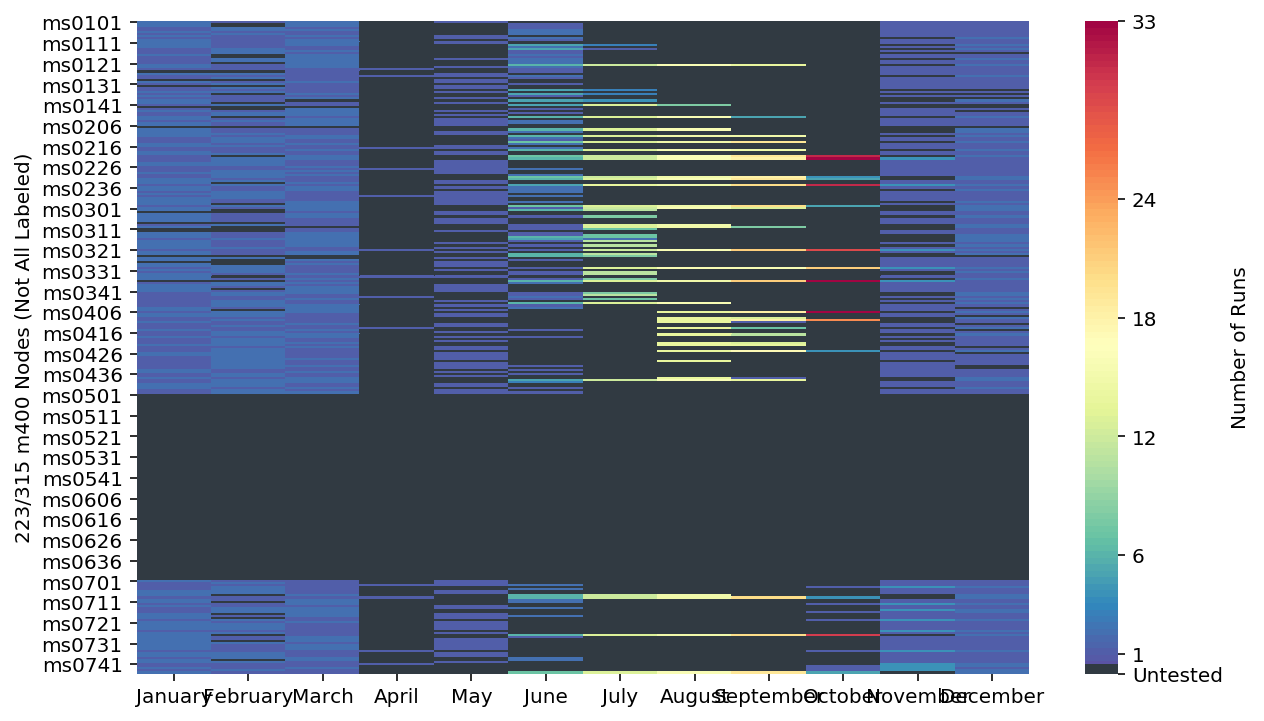

**Hardware Type: m510**

	Number of nodes tested/Total number of nodes: 221/270
	Total runs:  2007
	Min and max counts:  1 44
	Mean and median counts (rounded):  9 7


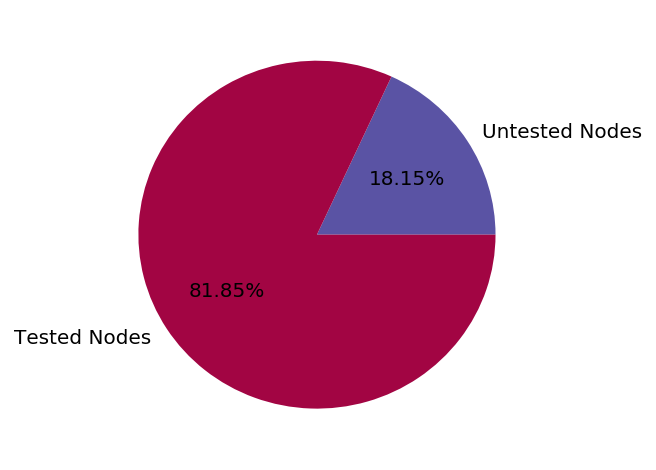

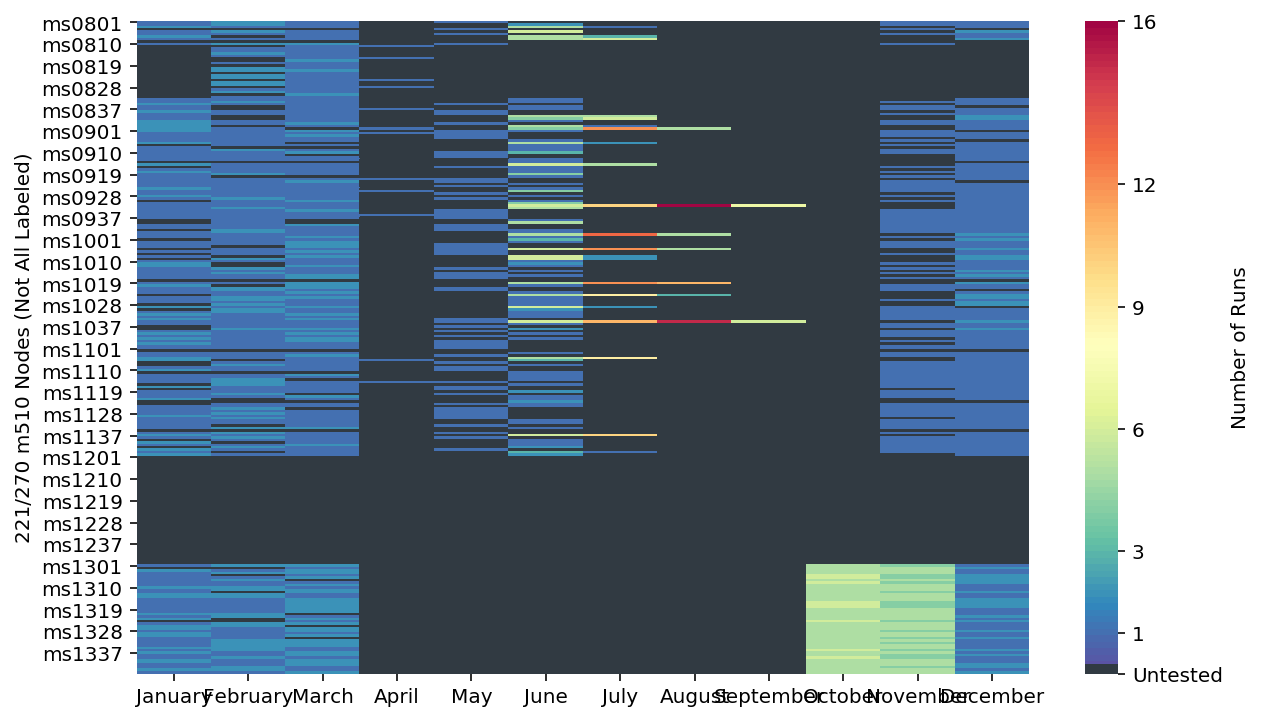

In [4]:
# Show converage: heatmaps for number of runs for all nodes during specific months

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def printmd(string):
    display(Markdown(string))
    
#subset = subset_df(db['env_info'], {"run_success": 1}, verbose=True)
print "Before Filtering:  " + str(len(db['env_info']))
subset = db['env_info'][db['env_info']['run_success'] != 0]
print "After failure Filtering:  " + str(len(subset))
subset = subset[subset["timestamp"] < 1522636071]
print "After timestamp Filtering:  " + str(len(subset))
months = sorted(set([dt.datetime.fromtimestamp(ts).month for ts in subset["timestamp"].unique()]))
print "\n"
print "Total Runs:  " + str(len(subset["run_uuid"].unique()))
print "Total Machines:  " + str(len(subset["nodeid"].unique()))
# print months

total_runs = []

for nodeid, runs in subset.groupby(["nodeid"]):
    total_runs.append(len(runs["run_uuid"].unique()))

print "Mean Runs per Node:  " + str(np.mean(total_runs))
print "Median Runs per Node:  " + str(np.median(total_runs))

for hw_type, grp in subset.groupby(["hw_type"]):
    
    node_specific = pd.DataFrame(columns=["nodeid", "run_count"])
    heatmap_df = pd.DataFrame(columns=months)
    
    for nodeid, subgrp in grp.groupby(["nodeid"]):
        subgrp["month"] = [dt.datetime.fromtimestamp(ts).month for ts in subgrp["timestamp"]]
        
        node_specific.loc[len(node_specific)] = [nodeid, subgrp["run_uuid"].count()]
        
        heatmap_df.loc[nodeid] = [float(subgrp[subgrp["month"] == m]["month"].count()) for m in months]  
   

    missing_nodes = [nodeid for nodeid in allnodes[hw_type] if nodeid not in node_specific["nodeid"].unique()]
    
    printmd('**Hardware Type: '+hw_type+'**')
    print "\tNumber of nodes tested/Total number of nodes: " + str(node_specific["nodeid"].count()) + '/' \
                                                             + str(len(allnodes[hw_type]))
    print "\tTotal runs: ", node_specific["run_count"].sum() 
    print "\tMin and max counts: ", node_specific["run_count"].min(), node_specific["run_count"].max()
    print "\tMean and median counts (rounded): ", "%d" % node_specific["run_count"].mean(), "%d" % node_specific["run_count"].median()

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.pie([len(missing_nodes), node_specific["nodeid"].count()], labels=['Untested Nodes','Tested Nodes'], 
           colors=['#5a53a4', '#a20543'], autopct='%1.2f%%')
    plot_show_and_save(fig, show_only=True)
    
    # Add data for missing nodes into heatmap_df
    for nodeid in missing_nodes:
        heatmap_df.loc[nodeid] = [float(0) for m in months]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_palette(spectral_cmap)
    sns.heatmap(heatmap_df.sort_index(), cmap = sns.color_palette(), ax=ax)
    
    # Formatting
    ax.set_xticklabels([calendar.month_name[m] for m in months])
    
    # Customize color bar
    cbar = fig.axes[-1]    
    max_runs = heatmap_df.max().max()
    tick_count = 4 # This excludes ticks "Untested" at 0, "1" at 1/max_runs, and max_run at 1.0
    labs_at_ticks = [int(max_runs * 1.0 / (tick_count + 1)) * (i + 1) for i in range(tick_count)] 
    vals_at_ticks = [l / max_runs for l in labs_at_ticks] 
    cbar.get_yaxis().set_ticks([0, 1/max_runs] + vals_at_ticks +  [1.0])
    cbar.set_yticklabels(["Untested", 1] + labs_at_ticks + [int(max_runs)])
    # Gray thick line for "Untested" at 0
    cbar.plot([0,1], [0, 0], spectral_cmap[0], lw=10) 
    cbar.set_ylabel("Number of Runs")
    
    # This is the proper way to show all y (node) ticks and labels. Most likely will be too many overlapping labels
    #ax.set_yticks(range(len(heatmap_df)))
    #ax.set_yticklabels(heatmap_df.index.values)
    
    # Instead, hide all y ticks and lables becuase this info is not that important on the heatmap
    #ax.set_yticks([])
    ax.set_ylabel("%d/%d %s Nodes (Not All Labeled)" % (node_specific["nodeid"].count(), len(allnodes[hw_type]), hw_type))
    
    plot_show_and_save(fig, show_only=True)

    #break

In [5]:
disk_all = pd.merge(subset, db['disk_info'], on=["run_uuid", "timestamp", "nodeuuid", "nodeid"])  
disk_all.sample(20).T

9206   \
run_uuid             21320b8d-0c51-4391-8d54-fa1a9d59af34   
timestamp                                      1509149086   
nodeid                                             ms1340   
nodeuuid             e734c000-8ffe-11e6-8c08-a53a3a50acf8   
gcc_ver                                             5.4.0   
version_hash     6e2eedd0f3c165252682c45e34764016278edd06   
total_mem                                           64GiB   
mem_clock_speed                                   2400MHz   
arch                                               x86_64   
run_success                                             1   
site                                                 utah   
nthreads                                               16   
nsockets                                                1   
hw_type                                              m510   
disk_name                                    /dev/nvme0n1   
disk_model                          THNSN5256GPU7 TOSHIBA   
disk_serial                                           NaN   
disk_size                                          238.5G   
npartitions                                             4   
disk_type                                             SSD   

                                                    5376   \
run_uuid             ba92363a-825a-4d1e-bd8b-e09cfbc44d52   
timestamp                                      1501243615   
nodeid                                             ms0221   
nodeuuid             688a0e7a-72da-11e4-85c8-179a28bd1b8c   
gcc_ver                                             5.4.0   
version_hash     6e2eedd0f3c165252682c45e34764016278edd06   
total_mem                                           62GiB   
mem_clock_speed                              Unknown(ARM)   
arch                                              aarch64   
run_success                                             1   
site                                                 utah   
nthreads                                                8   
nsockets                                                1   
hw_type                                              m400   
disk_name                                        /dev/sda   
disk_model                                    XR0120GEBLT   
disk_serial                                  14230C9CDAD0   
disk_size                                          111.8G   
npartitions                                             3   
disk_type                                             SSD   

                                                    11142  \
run_uuid             0d481bf3-d959-401a-8bc9-e85863f89b74   
timestamp                                      1513106875   
nodeid                                      c220g2-010832   
nodeuuid             2014c6ed-e772-11e5-a488-a3bb994732a6   
gcc_ver                                             5.4.0   
version_hash     08a0bec44063cdf3c360cd6e41f0aef75a9c9cc6   
total_mem                                          160GiB   
mem_clock_speed                                   2133MHz   
arch                                               x86_64   
run_success                                             1   
site                                                 wisc   
nthreads                                               40   
nsockets                                                2   
hw_type                                            c220g2   
disk_name                                        /dev/sda   
disk_model                                HUC101212CSS600   
disk_serial                              5000cca07298f868   
disk_size                                            1.1T   
npartitions                                             4   
disk_type                                             HDD   

                                                    2708   \
run_uuid             3b6d9e2a-ae57-4fa5-9284-05cecfa46ecc   
timestamp                                      1498480048   
nodeid                 

In [6]:
# No output confirms that there were no replacements (only single serial ID for a given disk/mount point)
# No data for m510s at Utah (NVMe)

disk_filt = disk_all[disk_all["run_success"] == 1]

for hw_type, grp in disk_filt.groupby(["hw_type"]):
    
    for (nodeid, disk_name), subgrp in grp.groupby(["nodeid", "disk_name"]):
        if len(subgrp["disk_serial"].unique()) > 1:
            print nodeid, disk_name, subgrp["disk_serial"].unique()
            if 'c220g1' not in nodeid:
                for index, row in subgrp.iterrows():
                    if not row.isnull().values.any():
                        print dt.datetime.fromtimestamp(row["timestamp"])

c220g1-030615 /dev/sdc ['CVWL444200U6480QGN' 'PHWL538001D0480QGN']


In [7]:
# Check unique values of various parameters
print "The earliest subset sample: ", dt.datetime.fromtimestamp(subset['timestamp'].min())
print "The latest subset sample: ", dt.datetime.fromtimestamp(subset['timestamp'].max())
print "\n"
print "Keys:", subset.keys()
print "\n"
print "gcc_ver Unique:"
for gcc_ver in subset["gcc_ver"].unique():
    print '\t', gcc_ver
    print '\t\tFirst record:', dt.datetime.fromtimestamp(subset[subset["gcc_ver"] == gcc_ver]['timestamp'].min())
    print '\t\tLast record:', dt.datetime.fromtimestamp(subset[subset["gcc_ver"] == gcc_ver]['timestamp'].max())
    print '\t\tNumber of Records:', len(subset[subset["gcc_ver"] == gcc_ver])
    print '\t\tUnique hwtypes:', subset[subset["gcc_ver"] == gcc_ver]['hw_type'].unique()
    if len(subset[subset["gcc_ver"] == gcc_ver]) < 100:
        gcc_unique_runuuids = subset[subset["gcc_ver"] == gcc_ver]["run_uuid"].unique()
print "\n"
print "version_hash Unique:"
for vhash in subset["version_hash"].unique():
    print '\t', vhash
    print '\t\tFirst record:', dt.datetime.fromtimestamp(subset[subset["version_hash"] == vhash]['timestamp'].min())
    print '\t\tLast record:', dt.datetime.fromtimestamp(subset[subset["version_hash"] == vhash]['timestamp'].max())
    print '\t\tNumber of Records:', len(subset[subset["version_hash"] == vhash])
print "\n"
print "ping version Unique:", db["ping_info"]["ping_version"].unique()
print "\n"
print "iperf3 version Unique:", db["iperf3_info"]["version"].unique()
print "\n"
print "fio version Unique:", db["fio_info"]["fio_version"].unique()
n = 0
fio_info = pd.merge(db['fio_info'], subset, on=["run_uuid", "timestamp", "nodeuuid", "nodeid"])
for fio_version in fio_info["fio_version"].unique():
    print '\t', fio_version
    if isinstance(fio_version, str):
        print '\t\tFirst record:', dt.datetime.fromtimestamp(fio_info[fio_info["fio_version"] == fio_version]['timestamp'].min())
        print '\t\tLast record:', dt.datetime.fromtimestamp(fio_info[fio_info["fio_version"] == fio_version]['timestamp'].max())
        print '\t\tNumber of Records:', len(fio_info[fio_info["fio_version"] == fio_version])
        print '\t\tUnique hwtypes:', fio_info[fio_info["fio_version"] == fio_version]['hw_type'].unique()
        if len(fio_info[fio_info["fio_version"] == fio_version]) < 100:
            fio_unique_runuuids = fio_info[fio_info["fio_version"] == fio_version]["run_uuid"].unique()

print "Null fio_versions:  "
for index, row in fio_info.iterrows():
    if row.isnull().values.any():
        print dt.datetime.fromtimestamp(row["timestamp"]), row["nodeid"], row["run_success"]
        n = n + 1;
    
print "Number of null fio_versions:  ", n

print "Are the anomalous gcc_ver and fio_version records from the same runs?  ", fio_unique_runuuids == gcc_unique_runuuids

The earliest subset sample:  2017-05-20 09:18:32
The latest subset sample:  2018-04-02 00:49:00


Keys: Index([u'run_uuid', u'timestamp', u'nodeid', u'nodeuuid', u'gcc_ver',
       u'version_hash', u'total_mem', u'mem_clock_speed', u'arch',
       u'run_success', u'site', u'nthreads', u'nsockets', u'hw_type'],
      dtype='object')


gcc_ver Unique:
	5.4.0
		First record: 2017-05-20 09:18:32
		Last record: 2018-04-02 00:49:00
		Number of Records: 10324
		Unique hwtypes: ['m400' 'c6320' 'c220g2' 'c220g1' 'c8220' 'm510']
	4.8.4
		First record: 2018-01-15 23:36:36
		Last record: 2018-03-07 23:36:58
		Number of Records: 76
		Unique hwtypes: ['c220g2' 'c220g1']


version_hash Unique:
	34b504cdf140bb0e06877e2dcf9836044664054d
		First record: 2017-05-20 09:18:32
		Last record: 2017-05-20 09:21:18
		Number of Records: 5
	e1c927e4b8958a4a922fa4de984aa428992d5990
		First record: 2017-05-22 12:04:35
		Last record: 2017-05-22 18:47:16
		Number of Records: 24
	ffa0b0cc7d010c36e7b154dfdb484dc476d930